<a href="https://colab.research.google.com/github/rafkama/Magang-BVK/blob/main/Inventory_and_Personalized_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Forecasting, Content, Collaborative Recommendation System**

Membuat sebuah sistem rekomendasi yang menggunakan 3 pendekatan; Content Based, Collaborative Filtering dan Forecasting. Content based dimanfaatkan ketika rekomendasi mendapatkan _cold start_. Collaborative dimanfaatkan ketika data sudah terkumpul dan direkomendasikan berdasarkan user lainnya. Pendekatan Forecasting adalah memberikan rekomendasi berdasarkan data kolektif seluruh pengguna dan tren sepanjang tahun.

# **Forecasting**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
from keras import optimizers
from keras.utils import plot_model
from keras.layers import Conv1D, MaxPooling1D, RepeatVector, TimeDistributed, Flatten
import os

# Ignore warnings
warnings.filterwarnings('ignore')

# Initialize notebook mode for offline Plotly
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Enable inline plotting
%matplotlib inline


## **Sales Data**

In [3]:
#Menampilkan sebagian data
df = pd.read_csv('salesdaily.csv')
df

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.00,3.670,3.40,32.40,7.0,0.0,0.0,2.00,2014,1,248,Thursday
1,1/3/2014,8.00,4.000,4.40,50.60,16.0,0.0,20.0,4.00,2014,1,276,Friday
2,1/4/2014,2.00,1.000,6.50,61.85,10.0,0.0,9.0,1.00,2014,1,276,Saturday
3,1/5/2014,4.00,3.000,7.00,41.10,8.0,0.0,3.0,0.00,2014,1,276,Sunday
4,1/6/2014,5.00,1.000,4.50,21.70,16.0,2.0,6.0,2.00,2014,1,276,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,10/4/2019,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,2019,10,276,Friday
2102,10/5/2019,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,2019,10,276,Saturday
2103,10/6/2019,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,2019,10,276,Sunday
2104,10/7/2019,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,2019,10,276,Monday


## **Preprocessing**

In [4]:
# Assuming df is your DataFrame
df['sales'] = df[['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']].sum(axis=1)

In [5]:
df

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name,sales
0,1/2/2014,0.00,3.670,3.40,32.40,7.0,0.0,0.0,2.00,2014,1,248,Thursday,48.470
1,1/3/2014,8.00,4.000,4.40,50.60,16.0,0.0,20.0,4.00,2014,1,276,Friday,107.000
2,1/4/2014,2.00,1.000,6.50,61.85,10.0,0.0,9.0,1.00,2014,1,276,Saturday,91.350
3,1/5/2014,4.00,3.000,7.00,41.10,8.0,0.0,3.0,0.00,2014,1,276,Sunday,66.100
4,1/6/2014,5.00,1.000,4.50,21.70,16.0,2.0,6.0,2.00,2014,1,276,Monday,58.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,10/4/2019,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,2019,10,276,Friday,52.723
2102,10/5/2019,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,2019,10,276,Saturday,47.580
2103,10/6/2019,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,2019,10,276,Sunday,67.490
2104,10/7/2019,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,2019,10,276,Monday,82.647


In [6]:
df.isnull().sum().sort_values(ascending=False)

,0
datum,0
M01AB,0
M01AE,0
N02BA,0
N02BE,0
N05B,0
N05C,0
R03,0
R06,0
Year,0


In [7]:
df.duplicated().any() # use df.drop_duplicates(inplace=True) -> if any duplicates exist in the dataframe

False

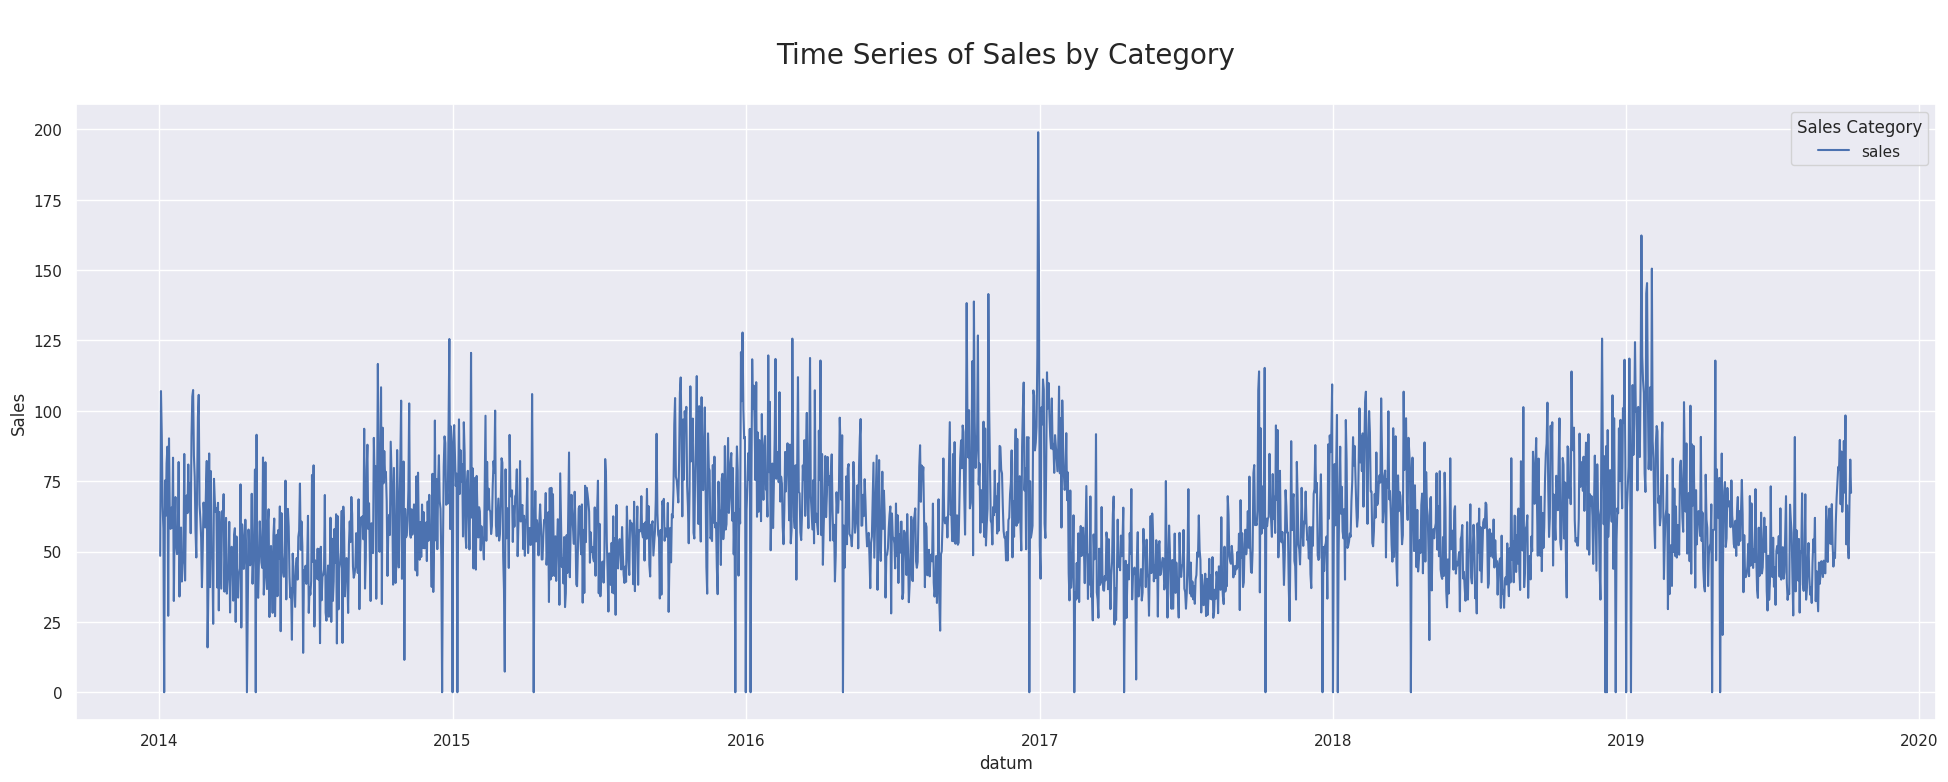

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'datum' is in datetime format
df['datum'] = pd.to_datetime(df['datum'])

# Select the columns for reshaping
columns_to_plot = ['sales'] #Pilih data disini

# Melt the DataFrame to long format
df_melted = df.melt(id_vars=['datum'], value_vars=columns_to_plot,
                    var_name='Sales Category', value_name='Sales')

# Set figure size
sns.set(rc={'figure.figsize':(24,8)})

# Create the line plot
ax = sns.lineplot(data=df_melted, x='datum', y='Sales', hue='Sales Category')

# Set the plot title
ax.set_title("\nTime Series of Sales by Category\n", fontsize=20)

# Show the plot
plt.show()

## **Data Splitting**

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Ensure the 'datum' column is in datetime format
df['datum'] = pd.to_datetime(df['datum'])

# Filter the data for years before 2019 and for the year 2019
df_before_2019 = df[df['Year'] < 2019]
df_2019 = df[df['Year'] == 2019]

# Select the 'M01AB' column for analysis
X = df_before_2019[['sales']].values  # Features (before 2019)
Y = df_2019[['sales']].values  # Target data for 2019 (test set)

# Split the data into 80% training and 20% validation for data before 2019
X_train, X_val = train_test_split(X, test_size=0.2, shuffle=False)

# Reshape the training and validation data to match the CNN-LSTM input
# Since 'M01AB' is a single column, the timesteps will be 1
timesteps = 1

# Reshape to (samples, timesteps, 1) for training and validation
X_train_series_sub = X_train.reshape((X_train.shape[0], timesteps, 1))
X_val_series_sub = X_val.reshape((X_val.shape[0], timesteps, 1))

# Reshape 2019 data for final testing
X_2019_series_sub = Y.reshape((Y.shape[0], timesteps, 1))

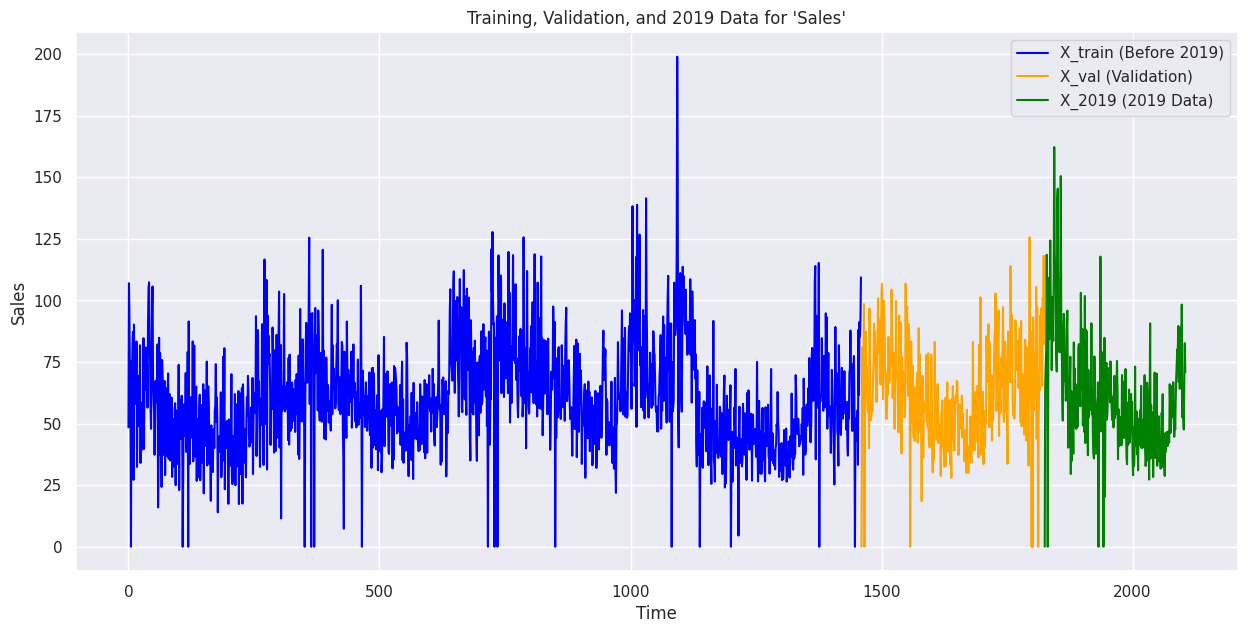

In [13]:
import matplotlib.pyplot as plt

# Reshape Y_train and Y_val to match shapes if needed
X_train_flat = X_train_series_sub.flatten()  # Flattening the data for plotting
X_val_flat = X_val_series_sub.flatten()      # Flattening validation data
X_2019_flat = X_2019_series_sub.flatten()    # Flattening 2019 data

# Prepare the index for plots
index_train = np.arange(0, len(X_train_flat))  # Index for X_train
index_val = np.arange(len(X_train_flat), len(X_train_flat) + len(X_val_flat))  # Index for X_val
index_2019 = np.arange(len(X_train_flat) + len(X_val_flat), len(X_train_flat) + len(X_val_flat) + len(X_2019_flat))  # Index for 2019

# Plot the X_train, X_val, and X_2019 data
plt.figure(figsize=(15, 7))

# Plot X_train
plt.plot(index_train, X_train_flat, label='X_train (Before 2019)', color='blue')

# Plot X_val
plt.plot(index_val, X_val_flat, label='X_val (Validation)', color='orange')

# Plot X_2019
plt.plot(index_2019, X_2019_flat, label='X_2019 (2019 Data)', color='green')

# Add titles and labels
plt.title("Training, Validation, and 2019 Data for 'Sales'")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()

# Show the plot
plt.show()



## **Model**

In [14]:
#KEEP

import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# Create the CNN-LSTM model
model_cnn_lstm = Sequential()

# Adding layers
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=1, activation='relu',
                           input_shape=(timesteps, 1))) # L2 regularization
model_cnn_lstm.add(MaxPooling1D(pool_size=1))

model_cnn_lstm.add(LSTM(50, activation='relu'))  # L2 regularization
model_cnn_lstm.add(Dropout(0.2))  # Dropout layer

model_cnn_lstm.add(Dense(1, kernel_regularizer=l2(0.01)))  # Single output for 'M01AB'

# Compile the model
adam = Adam()
model_cnn_lstm.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

#KEEP

In [15]:
# Fit the model
epochs = 50  # Adjust number of epochs as per requirement
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, X_train,
                                      validation_data=(X_val_series_sub, X_val),
                                      epochs=epochs, verbose=2)

Epoch 1/50
46/46 - 6s - 131ms/step - accuracy: 0.0110 - loss: 3629.1829 - val_accuracy: 0.0164 - val_loss: 3620.6108
Epoch 2/50
46/46 - 0s - 4ms/step - accuracy: 0.0110 - loss: 3097.2158 - val_accuracy: 0.0164 - val_loss: 2963.1409
Epoch 3/50
46/46 - 0s - 6ms/step - accuracy: 0.0110 - loss: 2484.4922 - val_accuracy: 0.0164 - val_loss: 2330.5190
Epoch 4/50
46/46 - 0s - 6ms/step - accuracy: 0.0110 - loss: 1971.2192 - val_accuracy: 0.0164 - val_loss: 1772.1814
Epoch 5/50
46/46 - 0s - 4ms/step - accuracy: 0.0110 - loss: 1345.9452 - val_accuracy: 0.0164 - val_loss: 1138.8074
Epoch 6/50
46/46 - 0s - 5ms/step - accuracy: 0.0110 - loss: 924.4458 - val_accuracy: 0.0164 - val_loss: 778.3910
Epoch 7/50
46/46 - 0s - 5ms/step - accuracy: 0.0110 - loss: 659.1590 - val_accuracy: 0.0164 - val_loss: 511.0270
Epoch 8/50
46/46 - 0s - 4ms/step - accuracy: 0.0110 - loss: 448.8232 - val_accuracy: 0.0164 - val_loss: 315.8952
Epoch 9/50
46/46 - 0s - 4ms/step - accuracy: 0.0110 - loss: 289.1874 - val_accuracy:

In [16]:


# Evaluate the model
loss, accuracy = model_cnn_lstm.evaluate(X_val_series_sub, X_val, verbose=0)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

# Predict on 2019 data
predictions_2019 = model_cnn_lstm.predict(X_2019_series_sub)

# Calculate the error on 2019 predictions
mse_2019 = mean_squared_error(Y, predictions_2019)
print(f'Mean Squared Error on 2019 data: {mse_2019}')

# Compare actual vs predicted M01AB for 2019
comparison = pd.DataFrame({
    'Actual': Y.flatten(),
    'Predicted': predictions_2019.flatten()
})

print(comparison.head())


Validation Loss: 0.9732138514518738, Validation Accuracy: 0.016438355669379234
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Mean Squared Error on 2019 data: 1.056961268123449
    Actual   Predicted
0    0.000    0.138368
1   65.677   64.842262
2   72.816   71.910080
3   80.070   79.071411
4  118.550  116.945541


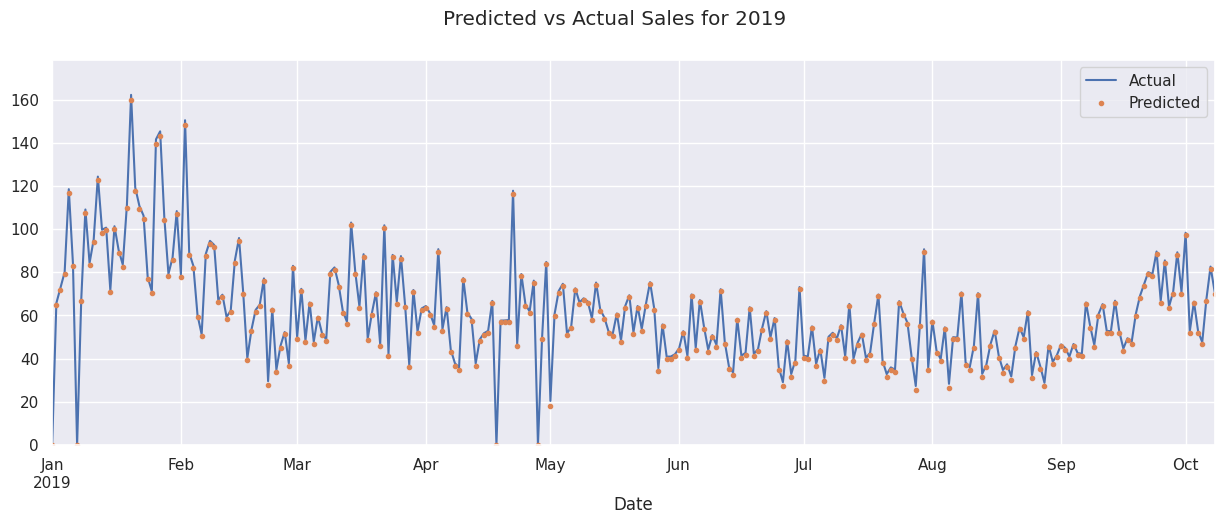

In [25]:
# Create a DataFrame to hold actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': Y.flatten(),
    'Predicted': predictions_2019.flatten(),
    'Date': df_2019['datum'].values  # Use the 'datum' as the date index
})

# Set the 'datum' as index
comparison_df.set_index('Date', inplace=True)

# Plotting the data
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Plot actual and predicted values
comparison_df[['Actual', 'Predicted']].plot(ax=ax, style=['-','.'])

# Optionally set x-axis bounds and y-axis limits
ax.set_xlim(comparison_df.index.min(), comparison_df.index.max())
ax.set_ylim(comparison_df['Actual'].min() * 0.9, comparison_df['Actual'].max() * 1.1)

# Add title
plt.suptitle('Predicted vs Actual Sales for 2019')

# Show the plot
plt.show()

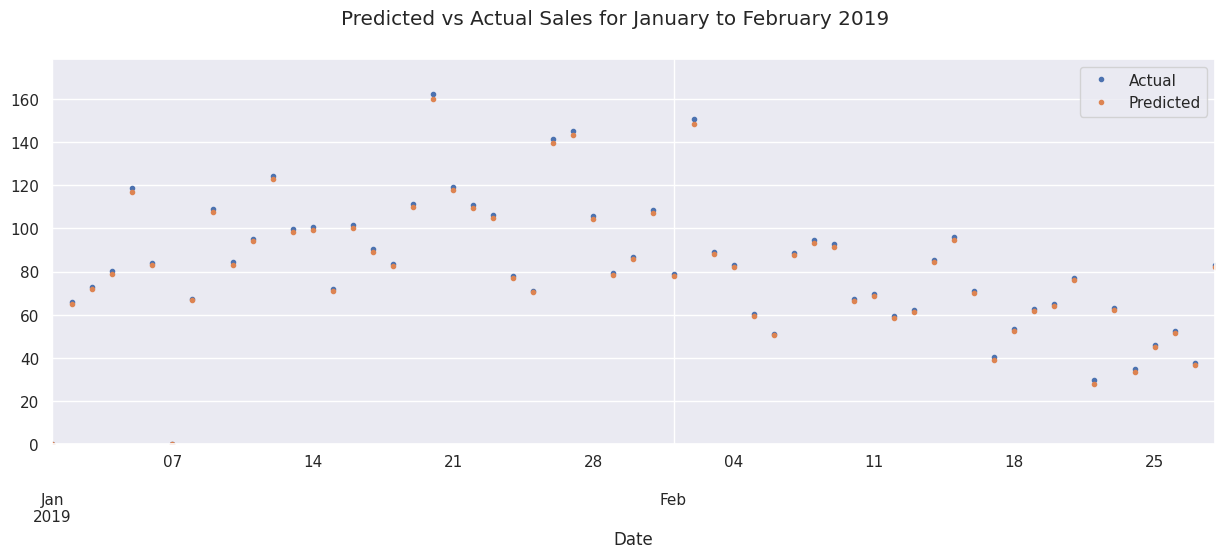

In [30]:
# Filter the comparison DataFrame to include only January and February 2019
comparison_jan_feb = comparison_df[(comparison_df.index >= '2019-01-01') & (comparison_df.index <= '2019-02-28')]

# Plotting the data (January to February)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Plot actual and predicted values for Jan-Feb
comparison_jan_feb[['Actual', 'Predicted']].plot(ax=ax, style=['.', '.'])

# Set x-axis bounds for January and February
ax.set_xlim(comparison_jan_feb.index.min(), comparison_jan_feb.index.max())

# Optionally set y-axis limits based on the actual values range
ax.set_ylim(comparison_jan_feb['Actual'].min() * 0.9, comparison_jan_feb['Actual'].max() * 1.1)

# Add title
plt.suptitle('Predicted vs Actual Sales for January to February 2019')

# Show the plot
plt.show()


# **Content Based**

In [69]:
#Menampilkan sebagian data
df2 = pd.read_csv('Drug.csv')
df2

,Condition,Drug,Indication,Type,Reviews,Effective,EaseOfUse,Satisfaction,Information
0,Acute Bacterial Sinusitis,Levofloxacin,On Label,RX,994 Reviews,2.52,3.01,1.84,\r\n\t\t\t\t\tLevofloxacin is used to treat a ...
1,Acute Bacterial Sinusitis,Levofloxacin,On Label,RX,994 Reviews,2.52,3.01,1.84,\r\n\t\t\t\t\tLevofloxacin is used to treat a ...
2,Acute Bacterial Sinusitis,Moxifloxacin,On Label,RX,755 Reviews,2.78,3.00,2.08,\r\n\t\t\t\t\t This is a generic drug. The ave...
3,Acute Bacterial Sinusitis,Azithromycin,On Label,RX,584 Reviews,3.21,4.01,2.57,\r\n\t\t\t\t\tAzithromycin is an antibiotic (m...
4,Acute Bacterial Sinusitis,Azithromycin,On Label,RX,584 Reviews,3.21,4.01,2.57,\r\n\t\t\t\t\tAzithromycin is an antibiotic (m...
...,...,...,...,...,...,...,...,...,...
2214,vulvovaginal candidiasis,Clotrimazole,On Label,OTC,2 Reviews,5.00,5.00,5.00,\r\n\t\t\t\t\tClotrimazole is used to treat sk...
2215,vulvovaginal candidiasis,Butoconazole Nitrate,On Label,RX,1 Reviews,5.00,5.00,5.00,\r\n\t\t\t\t\tThis medication is used to treat...
2216,vulvovaginal candidiasis,Clotrimazole,On Label,OTC,1 Reviews,5.00,4.00,5.00,\r\n\t\t\t\t\tClotrimazole is used to treat sk...
2217,vulvovaginal candidiasis,Butoconazole Nitrate,On Label,OTC,1 Reviews,5.00,5.00,5.00,\r\n\t\t\t\t\tThis medication is used to treat...


## **Preprocessing**

In [70]:
df2['Information'] = df2['Information'].str.replace("\r\n\t\t\t\t\t", "")


In [71]:
df2

,Condition,Drug,Indication,Type,Reviews,Effective,EaseOfUse,Satisfaction,Information
0,Acute Bacterial Sinusitis,Levofloxacin,On Label,RX,994 Reviews,2.52,3.01,1.84,Levofloxacin is used to treat a variety of bac...
1,Acute Bacterial Sinusitis,Levofloxacin,On Label,RX,994 Reviews,2.52,3.01,1.84,Levofloxacin is used to treat a variety of bac...
2,Acute Bacterial Sinusitis,Moxifloxacin,On Label,RX,755 Reviews,2.78,3.00,2.08,This is a generic drug. The average cash pric...
3,Acute Bacterial Sinusitis,Azithromycin,On Label,RX,584 Reviews,3.21,4.01,2.57,Azithromycin is an antibiotic (macrolide-type)...
4,Acute Bacterial Sinusitis,Azithromycin,On Label,RX,584 Reviews,3.21,4.01,2.57,Azithromycin is an antibiotic (macrolide-type)...
...,...,...,...,...,...,...,...,...,...
2214,vulvovaginal candidiasis,Clotrimazole,On Label,OTC,2 Reviews,5.00,5.00,5.00,Clotrimazole is used to treat skin infections ...
2215,vulvovaginal candidiasis,Butoconazole Nitrate,On Label,RX,1 Reviews,5.00,5.00,5.00,This medication is used to treat vaginal yeast...
2216,vulvovaginal candidiasis,Clotrimazole,On Label,OTC,1 Reviews,5.00,4.00,5.00,Clotrimazole is used to treat skin infections ...
2217,vulvovaginal candidiasis,Butoconazole Nitrate,On Label,OTC,1 Reviews,5.00,5.00,5.00,This medication is used to treat vaginal yeast...


In [72]:
df2['Drug'].duplicated().any()  # use df.drop_duplicates(inplace=True)

True

In [73]:
# Drop rows with duplicate values in the 'Drug' column
df2.drop_duplicates(subset='Drug', inplace=True)

In [74]:
df2

,Condition,Drug,Indication,Type,Reviews,Effective,EaseOfUse,Satisfaction,Information
0,Acute Bacterial Sinusitis,Levofloxacin,On Label,RX,994 Reviews,2.52,3.01,1.84,Levofloxacin is used to treat a variety of bac...
1,Acute Bacterial Sinusitis,Levofloxacin,On Label,RX,994 Reviews,2.52,3.01,1.84,Levofloxacin is used to treat a variety of bac...
2,Acute Bacterial Sinusitis,Moxifloxacin,On Label,RX,755 Reviews,2.78,3.00,2.08,This is a generic drug. The average cash pric...
3,Acute Bacterial Sinusitis,Azithromycin,On Label,RX,584 Reviews,3.21,4.01,2.57,Azithromycin is an antibiotic (macrolide-type)...
4,Acute Bacterial Sinusitis,Azithromycin,On Label,RX,584 Reviews,3.21,4.01,2.57,Azithromycin is an antibiotic (macrolide-type)...
...,...,...,...,...,...,...,...,...,...
2214,vulvovaginal candidiasis,Clotrimazole,On Label,OTC,2 Reviews,5.00,5.00,5.00,Clotrimazole is used to treat skin infections ...
2215,vulvovaginal candidiasis,Butoconazole Nitrate,On Label,RX,1 Reviews,5.00,5.00,5.00,This medication is used to treat vaginal yeast...
2216,vulvovaginal candidiasis,Clotrimazole,On Label,OTC,1 Reviews,5.00,4.00,5.00,Clotrimazole is used to treat skin infections ...
2217,vulvovaginal candidiasis,Butoconazole Nitrate,On Label,OTC,1 Reviews,5.00,5.00,5.00,This medication is used to treat vaginal yeast...


## **Building Model**

In [75]:
df2['Information'].head(5)

,Information
0,Levofloxacin is used to treat a variety of bac...
1,Levofloxacin is used to treat a variety of bac...
2,This is a generic drug. The average cash pric...
3,Azithromycin is an antibiotic (macrolide-type)...
4,Azithromycin is an antibiotic (macrolide-type)...


In [76]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['Information'] = df2['Information'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['Information'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(2219, 1284)

In [77]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [78]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['Drug']).drop_duplicates()

In [79]:
def get_recommendations(Drug, cosine_sim=cosine_sim):
    # Get the index of the anime that matches the title
    idx = indices[Drug]

    # Get the pairwise similarity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Filter recommendations where Rating > 3.5 [not used]
    filtered_recommendations = df2.iloc[anime_indices]
    filtered_recommendations = filtered_recommendations[filtered_recommendations['Satisfaction'] > 0.1]

    # Initialize an empty list to store valid recommendations
    valid_recommendations = []

    # Iterate through recommendations and filter out titles containing the input Name
    for index, row in filtered_recommendations.iterrows():
        # Skip recommendations that contain the input Name as a substring (case-insensitive)
        if Drug.lower() not in row['Drug'].lower():
            valid_recommendations.append(row)

        # Limit to 14 recommendations
        if len(valid_recommendations) == 10:
            break

    # Display the filtered recommendations
    print("\nRecommended Drug:")
    for recommendation in valid_recommendations:
        print(f"Title: {recommendation['Drug']}")

    return pd.DataFrame(valid_recommendations)[['Drug']]

In [80]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [81]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data (run these once if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process text (tokenize, remove stopwords, punctuation, and lemmatize)
def process_synopsis(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    keywords = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Join keywords with a comma separator
    return ','.join(keywords)

# Apply the function to the 'Synopsis' column and create a new column 'keywords'
df2['keywords'] = df2['Information'].apply(process_synopsis)

# View the first few rows to verify
df2[['Information', 'keywords']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Information,keywords
0,Levofloxacin is used to treat a variety of bac...,"levofloxacin,used,treat,variety,bacterial,infe..."
1,Levofloxacin is used to treat a variety of bac...,"levofloxacin,used,treat,variety,bacterial,infe..."
2,This is a generic drug. The average cash pric...,"generic,drug,average,cash,price,1,bottle,3ml,0..."
3,Azithromycin is an antibiotic (macrolide-type)...,"azithromycin,antibiotic,macrolidetype,generic,..."
4,Azithromycin is an antibiotic (macrolide-type)...,"azithromycin,antibiotic,macrolidetype,generic,..."


In [82]:
df2[['Drug', 'Condition', 'keywords']].head()

,Drug,Condition,keywords
0,Levofloxacin,Acute Bacterial Sinusitis,"levofloxacin,used,treat,variety,bacterial,infe..."
1,Levofloxacin,Acute Bacterial Sinusitis,"levofloxacin,used,treat,variety,bacterial,infe..."
2,Moxifloxacin,Acute Bacterial Sinusitis,"generic,drug,average,cash,price,1,bottle,3ml,0..."
3,Azithromycin,Acute Bacterial Sinusitis,"azithromycin,antibiotic,macrolidetype,generic,..."
4,Azithromycin,Acute Bacterial Sinusitis,"azithromycin,antibiotic,macrolidetype,generic,..."


In [83]:
# Define a function to split comma-separated strings into lists
def split_to_list(val):
    if isinstance(val, str):
        return val.split(',')  # Split string by comma
    return val  # If not a string, return the original value

# Apply the function to each column
features = ['Condition', 'keywords']
for feature in features:
    df2[feature] = df2[feature].apply(split_to_list)

# Check the first few rows to verify the result
df2[features].head()

,Condition,keywords
0,[Acute Bacterial Sinusitis],"[levofloxacin, used, treat, variety, bacterial..."
1,[Acute Bacterial Sinusitis],"[levofloxacin, used, treat, variety, bacterial..."
2,[Acute Bacterial Sinusitis],"[generic, drug, average, cash, price, 1, bottl..."
3,[Acute Bacterial Sinusitis],"[azithromycin, antibiotic, macrolidetype, gene..."
4,[Acute Bacterial Sinusitis],"[azithromycin, antibiotic, macrolidetype, gene..."


In [84]:
# No need to use literal_eval here
features = ['Condition', 'keywords']

# Verify that each feature has been converted to a list
for feature in features:
    df2[feature] = df2[feature].apply(split_to_list)

# Check the first few rows to verify
df2[features].head()

,Condition,keywords
0,[Acute Bacterial Sinusitis],"[levofloxacin, used, treat, variety, bacterial..."
1,[Acute Bacterial Sinusitis],"[levofloxacin, used, treat, variety, bacterial..."
2,[Acute Bacterial Sinusitis],"[generic, drug, average, cash, price, 1, bottl..."
3,[Acute Bacterial Sinusitis],"[azithromycin, antibiotic, macrolidetype, gene..."
4,[Acute Bacterial Sinusitis],"[azithromycin, antibiotic, macrolidetype, gene..."


In [85]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [86]:
# Apply clean_data function to your features.
features = ['Condition', 'keywords']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [87]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['Condition'])

# Apply the function to create the 'soup' column
df2['soup'] = df2.apply(create_soup, axis=1)

# Check the first few rows
df2[['Condition', 'keywords', 'soup']].head()

,Condition,keywords,soup
0,[acutebacterialsinusitis],"[levofloxacin, used, treat, variety, bacterial...",levofloxacin used treat variety bacterial infe...
1,[acutebacterialsinusitis],"[levofloxacin, used, treat, variety, bacterial...",levofloxacin used treat variety bacterial infe...
2,[acutebacterialsinusitis],"[generic, drug, average, cash, price, 1, bottl...",generic drug average cash price 1 bottle 3ml 0...
3,[acutebacterialsinusitis],"[azithromycin, antibiotic, macrolidetype, gene...",azithromycin antibiotic macrolidetype generic ...
4,[acutebacterialsinusitis],"[azithromycin, antibiotic, macrolidetype, gene...",azithromycin antibiotic macrolidetype generic ...


In [24]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [25]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [26]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['Drug'])

In [29]:
get_recommendations('Levofloxacin', cosine_sim2)


Recommended Drug:
Title: Amoxicillin
Title: Cefadroxil
Title: Erythromycin Stearate
Title: Cefpodoxime
Title: Sulfamethoxazole-Trimethoprim
Title: Cephalexin
Title: Imipenem-Cilastatin
Title: Moxifloxacin-Sod.Chloride(Iso)
Title: Ciprofloxacin Hcl
Title: Ciprofloxacin Hcl, Ciprofloxacin


,Drug
4,Amoxicillin
125,Cefadroxil
8,Erythromycin Stearate
449,Cefpodoxime
108,Sulfamethoxazole-Trimethoprim
112,Cephalexin
129,Imipenem-Cilastatin
10,Moxifloxacin-Sod.Chloride(Iso)
95,Ciprofloxacin Hcl
107,"Ciprofloxacin Hcl, Ciprofloxacin"
